# Image classification of IBSC compliant vs Non-compliant using SVM

By exploring the data it became apparant that the model was predicting everything as 'non-compliant' which I found out was due to using the wrong parameters in my train/test split, so I made the correct changes. 

Then by testing out different parameters within SVM like c and kernel I found that the best fit was c=3 and the rbf kernel for this data and context. 

Every time the model predicted compliant it was right however, only 43% of the actual “Compliant” samples were correctly identified. On the other side, all actual “Not Compliant” samples were correctly identified. This shows that the model is more inclined to predict "not compliant" with an accuracy of 69%.

In [2]:
import copy, pathlib, math
import PIL.Image as Image

import sklearn
import numpy
import matplotlib
import matplotlib.pyplot as plt

print("scikit-learn version:", sklearn.__version__)     # 1.1.3
print("numpy version:", numpy.__version__)              # 1.23.4
print("matplotlib version:", matplotlib.__version__)    # 3.6.2

scikit-learn version: 1.5.1
numpy version: 1.26.4
matplotlib version: 3.9.2


In [149]:
size = 300

def load_image(file, size):
    img = Image.open(file)
    img = img.resize((size, size))
    return numpy.array(img).flatten()

def load_labelled_images(path, size):
    labels = list()
    files = list()
    for file_info in [x for x in pathlib.Path(path).glob("**/*.jpg")]:
        labels.append(file_info.parts[1])
        files.append(str(file_info))
    imgs = numpy.array([load_image(f, size) for f in files])
    return imgs, numpy.array(labels)   

images, labels = load_labelled_images("./Scaling _dataset", size)
print("Loaded", len(images), "images in the following", len(numpy.unique(labels)), "classes:")
for label in numpy.unique(labels):
    print(label)


Loaded 41 images in the following 2 classes:
Compliant
Not Compliant


## Sampling the data

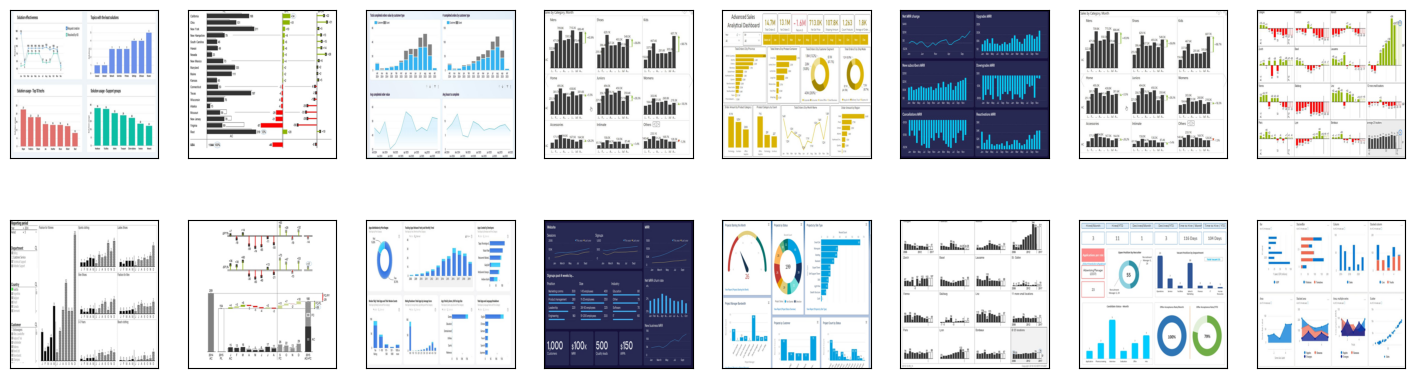

In [150]:
sample_size = 16

plotimgs = copy.deepcopy(images)
numpy.random.shuffle(plotimgs)
rows = plotimgs[:sample_size]

_, subplots = plt.subplots(nrows = math.ceil(sample_size/8), ncols = 8, figsize=(18, int(sample_size/3)))
subplots = subplots.flatten()
for i, x in enumerate(rows):
    subplots[i].imshow(numpy.reshape(x, [size, size, 3]))
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])

In [151]:
import numpy as np

images = np.array(images)
print("Images shape:", images.shape)

Images shape: (41, 270000)


## Preprocessing

In [200]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.3, random_state=42, stratify=labels)

# Function to print class counts
def print_class_counts(y, set_name):
    classes, counts = np.unique(y, return_counts=True)
    print(f"{set_name} set:")
    for cls, count in zip(classes, counts):
        print(f"  {cls}: {count}")
    print()

print_class_counts(y_train, "Train")
print_class_counts(y_test, "Test")

Train set:
  Compliant: 14
  Not Compliant: 14

Test set:
  Compliant: 7
  Not Compliant: 6



This shows that there is a balanced dataset.

## Applying SVM to dataset

In [192]:
from sklearn.svm import SVC
model = SVC(C=3, kernel='rbf')
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.6923076923076923


Using stratified K fold to make sure that the class distribution of the target variable is preserved in each fold during cross-validation. 

In [193]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, images, labels, cv=skf, scoring='accuracy')
print("Accuracy scores for each fold:", scores)
print("Average accuracy score:", np.mean(scores))

Accuracy scores for each fold: [0.66666667 0.625      0.625      0.625      0.625     ]
Average accuracy score: 0.6333333333333333


## Evaluation

In [ ]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

               precision    recall  f1-score   support

    Compliant       1.00      0.43      0.60         7
Not Compliant       0.60      1.00      0.75         6

     accuracy                           0.69        13
    macro avg       0.80      0.71      0.68        13
 weighted avg       0.82      0.69      0.67        13



With the recall being 1 for non compliant it is apparant that the model always predicts that the model is non compliant, which is why it always catches it but never when its compliant. (Due to this I added random state = 42 instead of 0 and I added stratify=labels so the model would have both compliant and non compliant in the train and test set)

We can visualize this as well: 

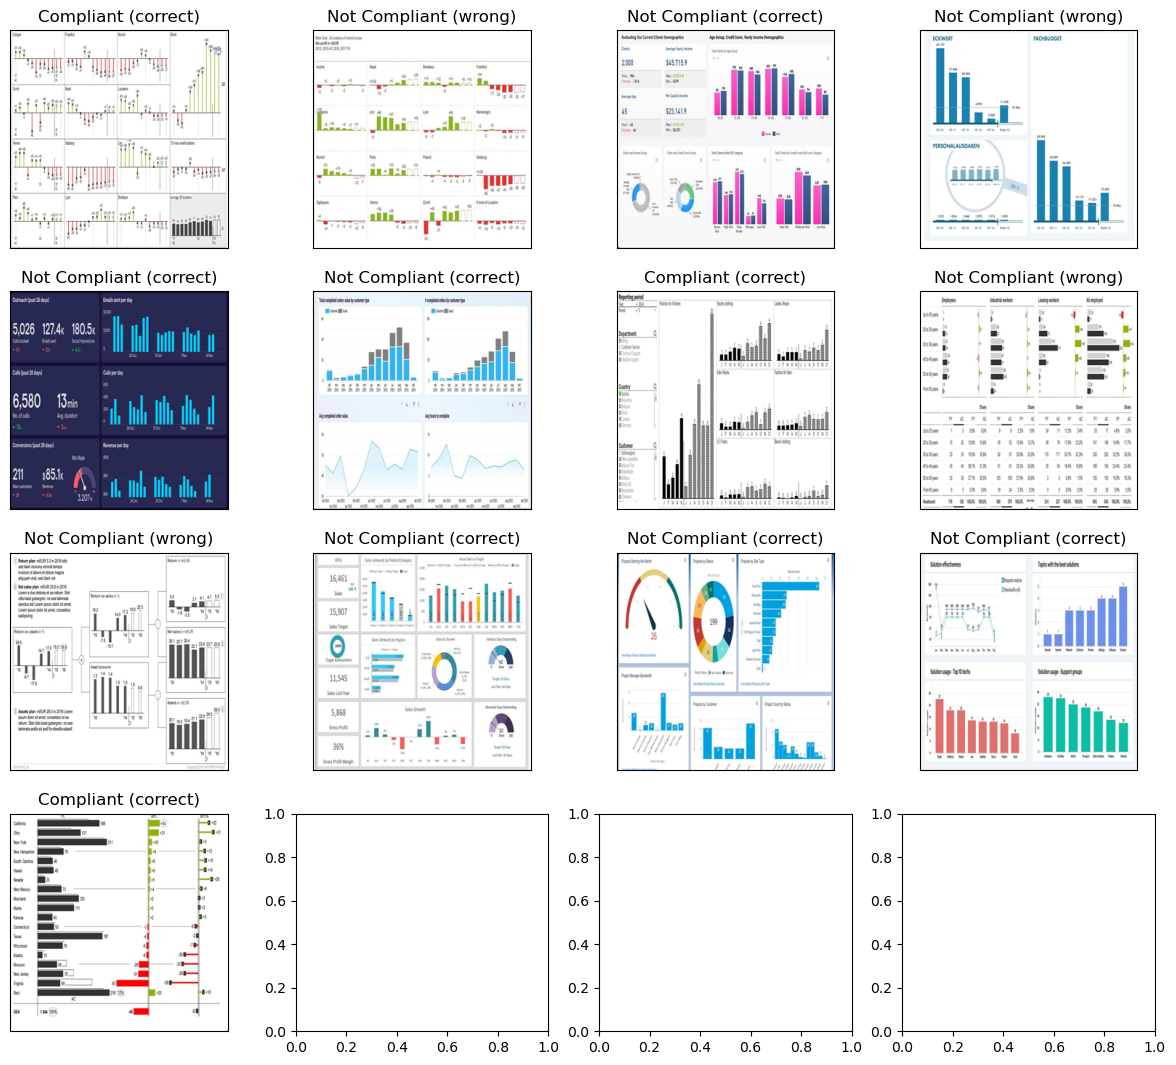

In [223]:
_, subplots = plt.subplots(nrows = math.ceil(len(X_test)/4), ncols = 4, figsize=(15, len(X_test)))
subplots = subplots.flatten()

for i, x in enumerate(X_test):
    subplots[i].imshow(numpy.reshape(x, [size, size, 3]))
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])
    subplots[i].set_title(predictions[i] + (" (correct)" if predictions[i] == y_test[i] else " (wrong)"))

# Exploring model and testing with parameters to get the best fitting model

## Plotting decision boundaries

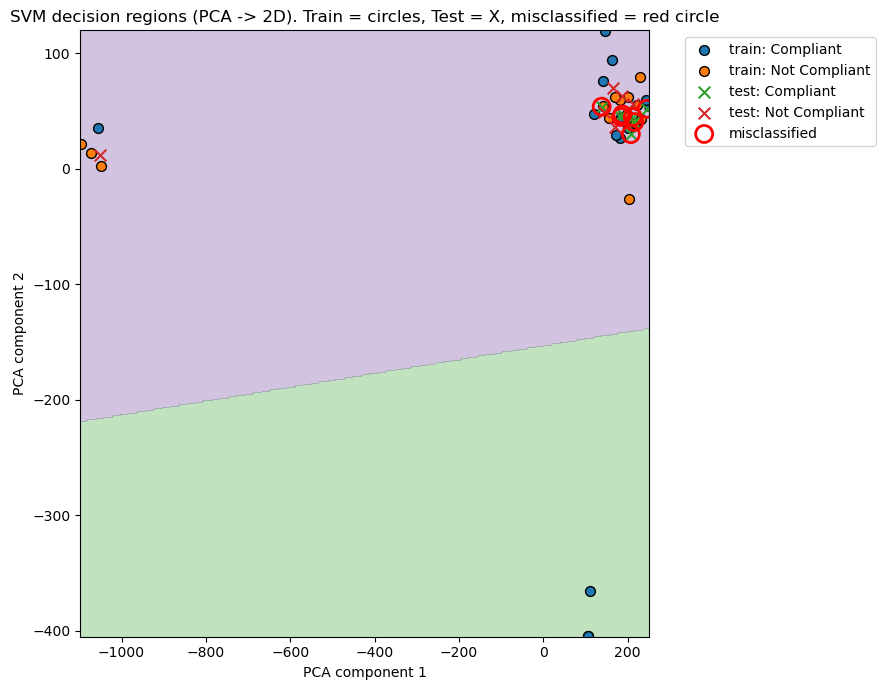

In [226]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Convert and basic checks
images = np.array(images)        
labels = np.array(labels)

# 1) Check for NaN/inf and fix if necessary
n_nan = np.isnan(images).sum()
n_posinf = np.isposinf(images).sum()
n_neginf = np.isneginf(images).sum()
if n_nan + n_posinf + n_neginf > 0:
    # Replace inf with nan then fill nan with 0 (or mean), using nan_to_num is simplest and safe
    images = np.nan_to_num(images, nan=0.0, posinf=0.0, neginf=0.0)

# 2) Optional: scale features before PCA (recommended)
scaler = StandardScaler()
try:
    images_scaled = scaler.fit_transform(images)
except Exception as e:
    print("Scaling failed:", e)
    images_scaled = images.astype(float)

# 3) Split (stratify ensures label balance)
X_train, X_test, y_train, y_test = train_test_split(
    images_scaled, labels,
    test_size=0.3, random_state=42,
    stratify=labels
)

# 4) PCA to 2D
pca = PCA(n_components=2, svd_solver='randomized', random_state=42)
X_train_2D = pca.fit_transform(X_train)
X_test_2D = pca.transform(X_test)

# 5) Check PCA outputs for finiteness
if not np.all(np.isfinite(X_train_2D)):
    raise ValueError("PCA result contains non-finite values. Check input data.")

# 6) Train SVM (linear)
clf = SVC(kernel='linear', probability=False, random_state=42)
clf.fit(X_train_2D, y_train)

# 7) Build a safe meshgrid
# Control max grid points to avoid memory blowup
MAX_GRID_POINTS = 200_000   # adjust if needed (200k is usually safe)
x_min, x_max = X_train_2D[:, 0].min() - 1.0, X_train_2D[:, 0].max() + 1.0
y_min, y_max = X_train_2D[:, 1].min() - 1.0, X_train_2D[:, 1].max() + 1.0

# Compute number of steps along each axis so nx*ny <= MAX_GRID_POINTS
# Use square-ish grid: nx = ny = floor(sqrt(MAX_GRID_POINTS))
nx = int(np.floor(np.sqrt(MAX_GRID_POINTS)))
ny = nx
# But if ranges are tiny, we still want a reasonable resolution (at least 50)
nx = max(50, nx)
ny = max(50, ny)

# Create linspace of length nx, ny
xx_lin = np.linspace(x_min, x_max, nx)
yy_lin = np.linspace(y_min, y_max, ny)
xx, yy = np.meshgrid(xx_lin, yy_lin)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# 8) Predict on the grid in batches to avoid memory blowup
batch_size = 50_000
n_points = grid_points.shape[0]
Z = np.empty(n_points, dtype=object)  # object dtype if labels are strings; adjust if numeric

for start in range(0, n_points, batch_size):
    end = min(start + batch_size, n_points)
    batch = grid_points[start:end]
    Z[start:end] = clf.predict(batch)

Z = Z.reshape(xx.shape)

# 9) Plotting
plt.figure(figsize=(9, 7))
# If labels are string classes, map to integers for colormap. But contourf accepts string arrays too rarely — use mapping:
unique_labels = np.unique(labels)
label_to_int = {lab: i for i, lab in enumerate(unique_labels)}
Z_int = np.vectorize(label_to_int.get)(Z)

plt.contourf(xx, yy, Z_int, alpha=0.3, levels=np.arange(len(unique_labels)+1)-0.5, cmap=plt.cm.Paired)

# Plot training points
for lab in unique_labels:
    idx = np.where(y_train == lab)
    plt.scatter(X_train_2D[idx, 0], X_train_2D[idx, 1], label=f"train: {lab}", edgecolors='k', s=50)

# Plot test points (and highlight misclassified ones)
y_test_pred = clf.predict(X_test_2D)
for lab in unique_labels:
    idx = np.where(y_test == lab)
    plt.scatter(X_test_2D[idx, 0], X_test_2D[idx, 1], marker='x', s=70, label=f"test: {lab}")

# Highlight misclassified test samples
mis_idx = np.where(y_test != y_test_pred)[0]
if mis_idx.size > 0:
    plt.scatter(X_test_2D[mis_idx, 0], X_test_2D[mis_idx, 1], facecolors='none', edgecolors='r', s=150, linewidths=2, label='misclassified')

plt.title("SVM decision regions (PCA -> 2D). Train = circles, Test = X, misclassified = red circle")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Testing with hyperparameter c

Having a higher c leads to weak regularization. The model fits the training data more strictly, which can give slightly better precision/recall if the classes are well separated, but risks overfitting if there’s noise.

Since theres a good difference between the two classes I will go with the higher c which leads to a better accuracy and precision.   

In [160]:
# modeling and evaluation for c=1
from sklearn.svm import SVC
model = SVC(C=1)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

from sklearn.metrics import classification_report
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

Accuracy: 0.5384615384615384
               precision    recall  f1-score   support

    Compliant       1.00      0.14      0.25         7
Not Compliant       0.50      1.00      0.67         6

     accuracy                           0.54        13
    macro avg       0.75      0.57      0.46        13
 weighted avg       0.77      0.54      0.44        13



In [161]:
# modeling and evaluation for c=0.5
from sklearn.svm import SVC
model = SVC(C=0.5)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

Accuracy: 0.5384615384615384
               precision    recall  f1-score   support

    Compliant       1.00      0.14      0.25         7
Not Compliant       0.50      1.00      0.67         6

     accuracy                           0.54        13
    macro avg       0.75      0.57      0.46        13
 weighted avg       0.77      0.54      0.44        13



In [164]:
# modeling and evaluation for c=2
from sklearn.svm import SVC
model = SVC(C=2)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

Accuracy: 0.6153846153846154
               precision    recall  f1-score   support

    Compliant       1.00      0.29      0.44         7
Not Compliant       0.55      1.00      0.71         6

     accuracy                           0.62        13
    macro avg       0.77      0.64      0.58        13
 weighted avg       0.79      0.62      0.57        13



In [173]:
# modeling and evaluation for c=3
from sklearn.svm import SVC
model = SVC(C=3)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

Accuracy: 0.6923076923076923
               precision    recall  f1-score   support

    Compliant       1.00      0.43      0.60         7
Not Compliant       0.60      1.00      0.75         6

     accuracy                           0.69        13
    macro avg       0.80      0.71      0.68        13
 weighted avg       0.82      0.69      0.67        13



## Testing with hyperparameter kernel

We will continue with c=3

Based on the outputs linear, rbf and sigmoid give the same accuracy. However, usually the rbf kernel is the best general-purpose kernel for image classification with an SVM because it can handle complex, non-linear relationships in data, which is typical for image datasets. So therefore, I will use the rbf kernel.

In [178]:
# modeling and evaluation for kernel = linear
from sklearn.svm import SVC
model = SVC(C=3, kernel="linear")
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

Accuracy: 0.6923076923076923
               precision    recall  f1-score   support

    Compliant       1.00      0.43      0.60         7
Not Compliant       0.60      1.00      0.75         6

     accuracy                           0.69        13
    macro avg       0.80      0.71      0.68        13
 weighted avg       0.82      0.69      0.67        13



In [179]:
# modeling and evaluation for kernel = poly
from sklearn.svm import SVC
model = SVC(C=3, kernel="poly")
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

Accuracy: 0.6153846153846154
               precision    recall  f1-score   support

    Compliant       0.58      1.00      0.74         7
Not Compliant       1.00      0.17      0.29         6

     accuracy                           0.62        13
    macro avg       0.79      0.58      0.51        13
 weighted avg       0.78      0.62      0.53        13



In [190]:
# modeling and evaluation for kernel = rbf
from sklearn.svm import SVC
model = SVC(C=3, kernel="rbf")
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

Accuracy: 0.6923076923076923
               precision    recall  f1-score   support

    Compliant       1.00      0.43      0.60         7
Not Compliant       0.60      1.00      0.75         6

     accuracy                           0.69        13
    macro avg       0.80      0.71      0.68        13
 weighted avg       0.82      0.69      0.67        13



In [182]:
# modeling and evaluation for kernel = sigmoid
from sklearn.svm import SVC
model = SVC(C=3, kernel="sigmoid")
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

Accuracy: 0.6923076923076923
               precision    recall  f1-score   support

    Compliant       1.00      0.43      0.60         7
Not Compliant       0.60      1.00      0.75         6

     accuracy                           0.69        13
    macro avg       0.80      0.71      0.68        13
 weighted avg       0.82      0.69      0.67        13

